In [1]:
# Modify the dataset loading section for Bengali (BN), using the correct path for the Bengali test set

import shutil
from pathlib import Path

# Define the paths where Kaggle has stored the input data
KAGGLE_INPUTS = Path("/kaggle/input/universal-dependencies")
KAGGLE_BENGALI_INPUTS = Path("/kaggle/input/ud-bengali")  # Specific path for Bengali files

# Expected file names from the pipeline config
NEEDED = [
    "en_ewt-ud-train.conllu", "en_ewt-ud-dev.conllu", "en_ewt-ud-test.conllu",   # English files
    "hi_hdtb-ud-train.conllu", "hi_hdtb-ud-dev.conllu", "hi_hdtb-ud-test.conllu",  # Hindi files
    "ur_udtb-ud-train.conllu", "ur_udtb-ud-dev.conllu", "ur_udtb-ud-test.conllu",    # Urdu files
    "bn_bru-ud-test.conllu",  # Correct Bengali test file path from /kaggle/input/ud-bengali
]

# Directory where we will store the files in the working environment
BASE_DIR = Path("./ud_data")
BASE_DIR.mkdir(parents=True, exist_ok=True)

# Function to copy required files from the Kaggle input directory to the local working directory
def copy_if_found(fname, source_path):
    dest = BASE_DIR / fname
    if dest.exists():
        return True  # File already exists, no need to copy
    # Check the Kaggle input path for the required file
    source_file = source_path / fname  # Directly reference the file name in the correct folder
    if source_file.exists():
        shutil.copy2(source_file, dest)  # Copy the file to the destination folder
        print(f"Copied: {source_file} -> {dest}")
        return True
    return False

# Check for missing files and copy them from the Kaggle input path
missing = []
for fname in NEEDED:
    # If the file is Bengali, check the specific Bengali folder
    if "bn_bru" in fname:
        ok = copy_if_found(fname, KAGGLE_BENGALI_INPUTS)
    else:
        ok = copy_if_found(fname, KAGGLE_INPUTS)
    
    if not ok:
        missing.append(fname)

# If any files are still missing, print a message
if missing:
    print("Still missing these files (add a dataset that contains them or upload manually):")
    for m in missing:
        print(" -", m)
else:
    print("All required UD files copied into", BASE_DIR.resolve())


Copied: /kaggle/input/universal-dependencies/en_ewt-ud-train.conllu -> ud_data/en_ewt-ud-train.conllu
Copied: /kaggle/input/universal-dependencies/en_ewt-ud-dev.conllu -> ud_data/en_ewt-ud-dev.conllu
Copied: /kaggle/input/universal-dependencies/en_ewt-ud-test.conllu -> ud_data/en_ewt-ud-test.conllu
Copied: /kaggle/input/universal-dependencies/hi_hdtb-ud-train.conllu -> ud_data/hi_hdtb-ud-train.conllu
Copied: /kaggle/input/universal-dependencies/hi_hdtb-ud-dev.conllu -> ud_data/hi_hdtb-ud-dev.conllu
Copied: /kaggle/input/universal-dependencies/hi_hdtb-ud-test.conllu -> ud_data/hi_hdtb-ud-test.conllu
Copied: /kaggle/input/universal-dependencies/ur_udtb-ud-train.conllu -> ud_data/ur_udtb-ud-train.conllu
Copied: /kaggle/input/universal-dependencies/ur_udtb-ud-dev.conllu -> ud_data/ur_udtb-ud-dev.conllu
Copied: /kaggle/input/universal-dependencies/ur_udtb-ud-test.conllu -> ud_data/ur_udtb-ud-test.conllu
Copied: /kaggle/input/ud-bengali/bn_bru-ud-test.conllu -> ud_data/bn_bru-ud-test.conllu


In [2]:
import os

# List files in the /kaggle/input directory
input_dir = '/kaggle/input/'
print("Files in /kaggle/input directory:", os.listdir(input_dir))


Files in /kaggle/input directory: ['ud-bengali', 'universal-dependencies']


In [2]:
from typing import List
import shutil
from pathlib import Path

# Define the languages used for training and testing
TRAIN_LANGS = ["en_ewt", "hi_hdtb", "ur_udtb"]  # Languages to train on
ZERO_SHOT_TEST_LANG = "bn_bcc"  # The language for zero-shot testing

# Define the source file paths for each language's train, dev, and test splits
UD_SOURCES = {
    "en_ewt": ("universal-dependencies", "en_ewt-ud-train.conllu", "en_ewt-ud-dev.conllu", "en_ewt-ud-test.conllu"),
    "hi_hdtb": ("universal-dependencies", "hi_hdtb-ud-train.conllu", "hi_hdtb-ud-dev.conllu", "hi_hdtb-ud-test.conllu"),
    "ur_udtb": ("universal-dependencies", "ur_udtb-ud-train.conllu", "ur_udtb-ud-dev.conllu", "ur_udtb-ud-test.conllu"),
    "bn_bcc": ("ud-bengali", "bn_bru-ud-test.conllu",),  # Bengali test file in a different folder
}

# Minimal CoNLL-U reader to get (words, upos, head, deprel)
# Skips multiword tokens (IDs like 1-2) and empty nodes (like 3.1)
def read_conllu(path: Path):
    sents = []
    words, upos, heads, rels = [], [], [], []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            if not line:
                if words:
                    sents.append((words, upos, heads, rels))
                    words, upos, heads, rels = [], [], [], []
                continue
            if line.startswith("#"):
                continue
            parts = line.split("\t")
            if len(parts) != 10:
                continue
            idx = parts[0]
            if "-" in idx or "." in idx:
                # skip multiword/empty
                continue
            form = parts[1]
            upos_tag = parts[3]
            head = parts[6]
            deprel = parts[7]
            try:
                head = int(head)
            except:
                head = 0
            words.append(form)
            upos.append(upos_tag)
            heads.append(head)
            rels.append(deprel)
    if words:
        sents.append((words, upos, heads, rels))
    return sents

# Fix: Load split from the correct directory (for online/offline use)
def load_split(lang_key: str, split: str):
    repo, train_f, dev_f, test_f = UD_SOURCES[lang_key]
    
    # Adjust the path to the correct dataset directory
    dataset_dir = Path(f"/kaggle/input/{repo}")  # Dynamically adjust for the subdirectories
    
    if lang_key == "bn_bcc":
        # Special case for Bengali (bn_bcc) test file
        fname = test_f  # Only test file for Bengali
    else:
        fname = {"train": train_f, "dev": dev_f, "test": test_f}[split]
    
    # Construct the correct path
    path = dataset_dir / fname  # Look in the respective subdirectory for the file
    
    if not path.exists():
        raise FileNotFoundError(f"Missing {path}. If offline, place it there manually.")
    return read_conllu(path)

# Build label vocab from training languages
def build_label_vocab(lang_keys: List[str]):
    rel2id = {"root": 0}
    id2rel = ["root"]
    
    for lk in lang_keys:
        for split in ["train", "dev", "test"]:
            try:
                data = load_split(lk, split)
            except Exception as e:
                continue
            for _, _, _, rels in data:
                for r in rels:
                    if r not in rel2id:
                        rel2id[r] = len(id2rel)
                        id2rel.append(r)
    
    return rel2id, id2rel

# Build the label vocab using the training languages and the zero-shot test language
rel2id, id2rel = build_label_vocab(TRAIN_LANGS + [ZERO_SHOT_TEST_LANG])
NUM_REL = len(id2rel)
print("Num dependency labels:", NUM_REL)

# Print out the label vocab for debugging
print("Label vocab:", id2rel)


Num dependency labels: 51
Label vocab: ['root', 'punct', 'flat', 'amod', 'nsubj', 'parataxis', 'obj', 'det', 'appos', 'case', 'nmod', 'aux', 'iobj', 'obl', 'mark', 'acl', 'ccomp', 'compound:prt', 'nummod', 'nsubj:pass', 'aux:pass', 'obl:agent', 'cop', 'compound', 'advmod', 'nsubj:outer', 'xcomp', 'nmod:poss', 'cc', 'conj', 'advcl', 'acl:relcl', 'expl', 'fixed', 'nmod:unmarked', 'det:predet', 'obl:unmarked', 'advcl:relcl', 'csubj', 'orphan', 'csubj:pass', 'vocative', 'discourse', 'nmod:desc', 'list', 'dislocated', 'reparandum', 'cc:preconj', 'csubj:outer', 'goeswith', 'dep']


In [13]:
import socket

try:
    print(socket.gethostbyname("huggingface.co"))
except Exception as e:
    print(f"DNS resolution failed: {e}")


3.170.185.14


In [3]:
# Multilingual dependency parsing with XLM-RoBERTa
!pip -q install transformers==4.44.2 accelerate==0.34.2 sentencepiece==0.2.0

import os, math, random, json, time
from pathlib import Path
from typing import List, Tuple
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModel

import matplotlib.pyplot as plt

# Reuse from your previous cells:
# - read_conllu, load_split
# - TRAIN_LANGS, ZERO_SHOT_TEST_LANG
# - rel2id, id2rel, NUM_REL

SEED = 13
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

MODEL_NAME = "xlm-roberta-base"   # good on Kaggle T4
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded:", MODEL_NAME)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 944.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 43.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizer loaded: xlm-roberta-base


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# --- PATCH: make UD_SOURCES 4-tuples and harden load_split for missing splits ---cell$

UD_SOURCES = {
    "en_ewt":  ("universal-dependencies", "en_ewt-ud-train.conllu", "en_ewt-ud-dev.conllu",  "en_ewt-ud-test.conllu"),
    "hi_hdtb": ("universal-dependencies", "hi_hdtb-ud-train.conllu", "hi_hdtb-ud-dev.conllu", "hi_hdtb-ud-test.conllu"),
    "ur_udtb": ("universal-dependencies", "ur_udtb-ud-train.conllu", "ur_udtb-ud-dev.conllu", "ur_udtb-ud-test.conllu"),
    # Bengali zero-shot: only test is available; train/dev are None placeholders
    "bn_bcc":  ("ud-bengali",              None,                      None,                     "bn_bru-ud-test.conllu"),
}

from pathlib import Path

def load_split(lang_key: str, split: str):
    """
    Returns list of sentences (words, upos, heads, rels) for the requested split.
    For languages without a given split (e.g., bn_bcc has only 'test'), raises FileNotFoundError.
    """
    try:
        repo, train_f, dev_f, test_f = UD_SOURCES[lang_key]
    except KeyError:
        raise KeyError(f"Unknown language key: {lang_key}")

    dataset_dir = Path(f"/kaggle/input/{repo}")

    if split == "train":
        fname = train_f
    elif split == "dev":
        fname = dev_f
    elif split == "test":
        fname = test_f
    else:
        raise ValueError(f"Unknown split: {split}")

    if fname is None:
        # e.g., bn_bcc has no train/dev
        raise FileNotFoundError(f"{lang_key} does not provide a '{split}' split.")

    path = dataset_dir / fname
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}. If offline, place it there manually.")

    return read_conllu(path)

print("PATCH OK: UD_SOURCES normalized; load_split hardened.")


PATCH OK: UD_SOURCES normalized; load_split hardened.


In [8]:
# We align on "first subword" per word and build a ROOT representation.cell5

def add_root(words, upos, heads, rels):
    return (["<ROOT>"] + words,
            ["ROOT"] + upos,
            [0] + heads,
            ["root"] + rels)

class UDSubwordDataset(Dataset):
    def __init__(self, lang_key:str, split:str):
        sents = load_split(lang_key, split)
        self.items = []
        for words, upos, heads, rels in sents:
            words, upos, heads, rels = add_root(words, upos, heads, rels)
            # tokenize with is_split_into_words to get mapping
            enc = tokenizer(words, is_split_into_words=True, add_special_tokens=True, return_tensors=None)
            input_ids = enc["input_ids"]
            attention_mask = enc["attention_mask"]
            # map word->first subword index
            word_ids = enc.word_ids()
            first_idx = {}
            for i, wid in enumerate(word_ids):
                if wid is None: 
                    continue
                if wid not in first_idx:
                    first_idx[wid] = i
            # Build list of word_start positions in subwords order (0..len(words)-1)
            word_starts = [first_idx[w] for w in range(len(words))]
            # Labels
            Lw = len(words)
            # Clamp invalid heads (rare, just to be safe)
            heads = [h if 0 <= h < Lw else 0 for h in heads]
            rel_ids = [rel2id.get(r, 0) for r in rels]
            self.items.append({
                "input_ids": torch.tensor(input_ids, dtype=torch.long),
                "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
                "word_starts": torch.tensor(word_starts, dtype=torch.long),
                "heads": torch.tensor(heads, dtype=torch.long),
                "rels": torch.tensor(rel_ids, dtype=torch.long),
                "upos": upos,   # keep for punct filtering if needed
            })
    def __len__(self): return len(self.items)
    def __getitem__(self, idx): return self.items[idx]

def pad_1d(seqs, pad_val=0):
    maxL = max(x.size(0) for x in seqs)
    out = torch.full((len(seqs), maxL), pad_val, dtype=seqs[0].dtype)
    for i, x in enumerate(seqs):
        out[i, :x.size(0)] = x
    return out

def pad_2d(seqs, pad_val=0):
    maxL = max(x.size(0) for x in seqs)
    out = torch.full((len(seqs), maxL), pad_val, dtype=seqs[0].dtype)
    for i, x in enumerate(seqs):
        out[i, :x.size(0)] = x
    return out

def collate_subword(batch):
    # subword tensors
    input_ids = [b["input_ids"] for b in batch]
    attn_mask = [b["attention_mask"] for b in batch]
    max_sub = max(x.size(0) for x in input_ids)
    pad_id = tokenizer.pad_token_id
    input_ids_pad = torch.full((len(batch), max_sub), pad_id, dtype=torch.long)
    attn_mask_pad = torch.zeros((len(batch), max_sub), dtype=torch.long)
    for i, (ids, m) in enumerate(zip(input_ids, attn_mask)):
        L = ids.size(0)
        input_ids_pad[i, :L] = ids
        attn_mask_pad[i, :L] = m

    # word-level
    word_starts = [b["word_starts"] for b in batch]
    max_words = max(x.size(0) for x in word_starts)
    # We'll pad with -1 for starts (ignored where mask==0)
    ws_pad = torch.full((len(batch), max_words), -1, dtype=torch.long)
    lengths_words = torch.zeros(len(batch), dtype=torch.long)
    for i, ws in enumerate(word_starts):
        ws_pad[i, :ws.size(0)] = ws
        lengths_words[i] = ws.size(0)

    heads = [b["heads"] for b in batch]
    rels  = [b["rels"]  for b in batch]
    heads_pad = torch.zeros((len(batch), max_words), dtype=torch.long)  # head 0..T-1
    rels_pad  = torch.zeros((len(batch), max_words), dtype=torch.long)
    mask_words = torch.zeros((len(batch), max_words), dtype=torch.long)
    for i, (h, r) in enumerate(zip(heads, rels)):
        Lw = h.size(0)
        heads_pad[i, :Lw] = h
        rels_pad[i, :Lw]  = r
        mask_words[i, :Lw] = 1

    upos = [b["upos"] for b in batch]  # list of lists (length varies)

    return (input_ids_pad, attn_mask_pad, ws_pad, lengths_words,
            heads_pad, rels_pad, mask_words, upos)


In [9]:
#cell6
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, p=0.33):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.act = nn.LeakyReLU(0.1)
        self.drop = nn.Dropout(p)
    def forward(self, x): return self.drop(self.act(self.fc(x)))

class Biaffine(nn.Module):
    def __init__(self, in1, in2, out=1, bias_x=True, bias_y=True):
        super().__init__()
        self.bias_x = bias_x; self.bias_y = bias_y
        self.U = nn.Parameter(torch.empty(out, in1 + bias_x, in2 + bias_y))
        nn.init.xavier_uniform_(self.U)
    def forward(self, x, y):  # x:[B,T,D1], y:[B,T,D2]
        if self.bias_x: x = torch.cat([x, x.new_ones(x.size(0), x.size(1), 1)], dim=-1)
        if self.bias_y: y = torch.cat([y, y.new_ones(y.size(0), y.size(1), 1)], dim=-1)
        # [B,out,T,T]
        return torch.einsum("bxi,oij,byj->boxy", x, self.U, y)

class XLMRParser(nn.Module):
    def __init__(self, model_name:str, rel_size:int,
                 mlp_arc=500, mlp_rel=100, dropout=0.33):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hid = self.encoder.config.hidden_size
        # learnable ROOT embedding at word-level
        self.root = nn.Parameter(torch.zeros(1, 1, hid))
        nn.init.xavier_uniform_(self.root)

        self.mlp_arc_h = MLP(hid, mlp_arc, dropout)
        self.mlp_arc_d = MLP(hid, mlp_arc, dropout)
        self.mlp_rel_h = MLP(hid, mlp_rel, dropout)
        self.mlp_rel_d = MLP(hid, mlp_rel, dropout)

        self.arc_biaff = Biaffine(mlp_arc, mlp_arc, out=1)
        self.rel_biaff = Biaffine(mlp_rel, mlp_rel, out=rel_size)

    def select_word_reps(self, enc_out, word_starts, mask_words):
        # enc_out: [B, Lsub, H], word_starts: [B, T] (subword idx, -1 padded), mask_words:[B,T]
        B, _, H = enc_out.size()
        T = word_starts.size(1)
        # Clamp negatives to zero for gather (ignored later by mask)
        idx = word_starts.clamp(min=0)
        idx = idx.unsqueeze(-1).expand(B, T, H)  # [B,T,H]
        gathered = enc_out.gather(1, idx)  # [B,T,H] (positions for words incl ROOT)
        # Prepend learned ROOT as word 0 (we already included ROOT token in words,
        # but we prefer a clean, stable learned vector)
        # Here, replace the first word vector with root parameter:
        root = self.root.expand(B, -1, -1)       # [B,1,H]
        gathered[:, 0:1, :] = root
        return gathered

    def forward(self, input_ids, attn_mask, word_starts, mask_words):
        enc = self.encoder(input_ids=input_ids, attention_mask=attn_mask).last_hidden_state  # [B,Lsub,H]
        words_H = self.select_word_reps(enc, word_starts, mask_words)  # [B,T,H]
        arc_h = self.mlp_arc_h(words_H)
        arc_d = self.mlp_arc_d(words_H)
        rel_h = self.mlp_rel_h(words_H)
        rel_d = self.mlp_rel_d(words_H)
        s_arc = self.arc_biaff(arc_d, arc_h).squeeze(1)  # [B,T,T]
        s_rel = self.rel_biaff(rel_d, rel_h)             # [B,R,T,T]
        return s_arc, s_rel


In [11]:
#cell7
def compute_loss(scores_arc, scores_rel, gold_heads, gold_rels, mask_words):
    # Exclude position 0 (ROOT as dependent) from loss
    mask = mask_words.clone()
    mask[:, 0] = 0
    B, T, _ = scores_arc.size()

    # ARC
    arc_loss = nn.functional.cross_entropy(scores_arc.transpose(1,2), gold_heads, reduction="none")
    arc_loss = (arc_loss * mask).sum() / (mask.sum().clamp(min=1))

    # REL — gather scores at gold heads
    head_idx = gold_heads.unsqueeze(1).unsqueeze(1).expand(B, scores_rel.size(1), T, 1)
    rel_sel = torch.gather(scores_rel, 3, head_idx).squeeze(3)  # [B,R,T]
    rel_loss = nn.functional.cross_entropy(rel_sel.transpose(1,2), gold_rels, reduction="none")
    rel_loss = (rel_loss * mask).sum() / (mask.sum().clamp(min=1))

    return arc_loss + rel_loss, arc_loss.item(), rel_loss.item()

@torch.no_grad()
def decode(scores_arc, scores_rel, mask_words):
    heads = scores_arc.argmax(-1)  # [B,T]
    B, T, _ = scores_arc.size()
    head_idx = heads.unsqueeze(1).unsqueeze(1).expand(B, scores_rel.size(1), T, 1)
    rel_sel = torch.gather(scores_rel, 3, head_idx).squeeze(3)  # [B,R,T]
    rels = rel_sel.argmax(1)
    # zero out pads
    heads = heads * mask_words
    rels  = rels  * mask_words
    return heads, rels

@torch.no_grad()
def eval_loader(model, loader, keep_punct=True):
    model.eval()
    total = correct_head = correct_label = correct_both = 0
    for (input_ids, attn_mask, ws, Lw, gold_h, gold_r, mw, upos) in loader:
        input_ids = input_ids.to(DEVICE)
        attn_mask = attn_mask.to(DEVICE)
        ws = ws.to(DEVICE)
        gold_h = gold_h.to(DEVICE)
        gold_r = gold_r.to(DEVICE)
        mw = mw.to(DEVICE)

        s_arc, s_rel = model(input_ids, attn_mask, ws, mw)
        pred_h, pred_r = decode(s_arc, s_rel, mw)

        # count excluding ROOT and (optional) punctuation
        for b in range(input_ids.size(0)):
            T = Lw[b].item()
            for i in range(1, T):  # skip dependent ROOT
                if not keep_punct:
                    # rely on UPOS tag from original data
                    if i < len(upos[b]) and upos[b][i] in {"PUNCT", "SYM"}:
                        continue
                total += 1
                gh, gr = gold_h[b, i].item(), gold_r[b, i].item()
                ph, pr = pred_h[b, i].item(), pred_r[b, i].item()
                if ph == gh: correct_head += 1
                if pr == gr: correct_label += 1
                if ph == gh and pr == gr: correct_both += 1

    if total == 0:
        return {"UAS": 0.0, "LAS": 0.0, "LS": 0.0}
    return {
        "UAS": 100*correct_head/total,
        "LAS": 100*correct_both/total,
        "LS":  100*correct_label/total
    }

def make_loaders(lang_key, split_train="train", bsz=8, shuffle=True):
    ds_tr = UDSubwordDataset(lang_key, split_train)
    ds_de = UDSubwordDataset(lang_key, "dev")
    dl_tr = DataLoader(ds_tr, batch_size=bsz, shuffle=shuffle, collate_fn=collate_subword)
    dl_de = DataLoader(ds_de, batch_size=bsz, shuffle=False, collate_fn=collate_subword)
    return ds_tr, ds_de, dl_tr, dl_de

def make_test_loader(lang_key, split="test", bsz=16):
    ds = UDSubwordDataset(lang_key, split)
    dl = DataLoader(ds, batch_size=bsz, shuffle=False, collate_fn=collate_subword)
    return ds, dl


In [17]:
# --- PATCH: fix relation loss shape (classes must be at dim=1) ---

def compute_loss(scores_arc, scores_rel, gold_heads, gold_rels, mask_words):
    # Exclude ROOT (position 0 as dependent) from loss
    mask = mask_words.clone()
    mask[:, 0] = 0
    B, T, _ = scores_arc.size()

    # ARC loss: scores_arc [B,T,T], put classes (heads) at dim=1
    arc_loss = nn.functional.cross_entropy(scores_arc.transpose(1,2), gold_heads, reduction="none")
    arc_loss = (arc_loss * mask).sum() / (mask.sum().clamp(min=1))

    # REL loss:
    # scores_rel: [B, R, T, T]
    # gather at gold heads -> rel_sel: [B, R, T]  (classes=R at dim=1 ✅)
    head_idx = gold_heads.unsqueeze(1).unsqueeze(-1).expand(B, scores_rel.size(1), T, 1)
    rel_sel = torch.gather(scores_rel, 3, head_idx).squeeze(3)  # [B, R, T]

    # Feed directly (NO transpose): input [B, C=R, T], target [B, T]
    rel_loss = nn.functional.cross_entropy(rel_sel, gold_rels, reduction="none")
    rel_loss = (rel_loss * mask).sum() / (mask.sum().clamp(min=1))

    return arc_loss + rel_loss, arc_loss.item(), rel_loss.item()

print("✅ Relation loss fixed (no transpose).")


✅ Relation loss fixed (no transpose).


In [18]:
#cell8
def train_one_language(model, dl_train, dl_dev, *, epochs:int, lr:float, save_path:str, print_every:int=50):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best = -1.0
    history = []
    step = 0
    for ep in range(1, epochs+1):
        running = 0.0
        for i, batch in enumerate(dl_train, start=1):
            (input_ids, attn_mask, ws, Lw, gold_h, gold_r, mw, _upos) = batch
            input_ids = input_ids.to(DEVICE)
            attn_mask = attn_mask.to(DEVICE)
            ws = ws.to(DEVICE)
            gold_h = gold_h.to(DEVICE)
            gold_r = gold_r.to(DEVICE)
            mw = mw.to(DEVICE)

            s_arc, s_rel = model(input_ids, attn_mask, ws, mw)
            loss, la, lr_ = compute_loss(s_arc, s_rel, gold_h, gold_r, mw)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            running += loss.item(); step += 1
            if i % print_every == 0:
                print(f"[ep {ep} step {step}] loss={running/print_every:.4f} (arc={la:.3f} rel={lr_:.3f})")
                running = 0.0

        metrics = eval_loader(model, dl_dev, keep_punct=True)
        history.append({"epoch": ep, **metrics})
        print(f"Epoch {ep} DEV -> UAS={metrics['UAS']:.2f}  LAS={metrics['LAS']:.2f}  (LS={metrics['LS']:.2f})")
        if metrics["LAS"] > best:
            best = metrics["LAS"]
            torch.save({"state_dict": model.state_dict()}, save_path)
            print(f"  -> Saved best to {save_path} (LAS={best:.2f})")
    return history, best


In [19]:
#cell9
CHECKPOINT_DIR = Path("./checkpoints_xlmr")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
ckpt_en = str(CHECKPOINT_DIR / "best-EN-xlmr.ckpt")
ckpt_hi = str(CHECKPOINT_DIR / "best-HI-xlmr.ckpt")
ckpt_ur = str(CHECKPOINT_DIR / "final-UR-xlmr.ckpt")

# DataLoaders (smaller batch sizes fit T4 comfortably; adjust up if memory allows)
_, _, en_tr, en_de = make_loaders("en_ewt", bsz=8, shuffle=True)
_, _, hi_tr, hi_de = make_loaders("hi_hdtb", bsz=8, shuffle=True)
_, _, ur_tr, ur_de = make_loaders("ur_udtb", bsz=8, shuffle=True)
bn_ds, bn_ts = make_test_loader(ZERO_SHOT_TEST_LANG, split="test", bsz=16)

# Init model
model = XLMRParser(MODEL_NAME, rel_size=NUM_REL, mlp_arc=600, mlp_rel=150, dropout=0.33).to(DEVICE)

results = {}

# 0) BN zero-shot BEFORE any training
print("\n[0] BN zero-shot (untrained parser heads)")
results["bn_before"] = eval_loader(model, bn_ts, keep_punct=True)
print("BN before:", results["bn_before"])

# 1) Train on EN
print("\n[1] Train on EN (en_ewt)")
hist_en, best_en = train_one_language(model, en_tr, en_de, epochs=3, lr=3e-5, save_path=ckpt_en)
state = torch.load(ckpt_en, map_location=DEVICE)
model.load_state_dict(state["state_dict"])
results["en_dev"] = eval_loader(model, en_de)
print("EN dev (best):", results["en_dev"])

# 2) Continue on HI
print("\n[2] Continue on HI (hi_hdtb)")
hist_hi, best_hi = train_one_language(model, hi_tr, hi_de, epochs=3, lr=2e-5, save_path=ckpt_hi)
state = torch.load(ckpt_hi, map_location=DEVICE)
model.load_state_dict(state["state_dict"])
results["hi_dev"] = eval_loader(model, hi_de)
print("HI dev (best):", results["hi_dev"])

# 3) Continue on UR
print("\n[3] Continue on UR (ur_udtb)")
hist_ur, best_ur = train_one_language(model, ur_tr, ur_de, epochs=3, lr=2e-5, save_path=ckpt_ur)
state = torch.load(ckpt_ur, map_location=DEVICE)
model.load_state_dict(state["state_dict"])
results["ur_dev"] = eval_loader(model, ur_de)
print("UR dev (final):", results["ur_dev"])

# 4) Final test on BN
print("\n[4] Final test on BN (bn_bcc)")
results["bn_after"] = eval_loader(model, bn_ts, keep_punct=True)
print("BN after:", results["bn_after"])

# Save histories
with open("xlmr_training_histories.json", "w") as f:
    json.dump({
        "hist_en": hist_en, "hist_hi": hist_hi, "hist_ur": hist_ur, "results": results
    }, f, indent=2)

print("\nArtifacts:")
print(" - Checkpoints:", ckpt_en, ckpt_hi, ckpt_ur)
print(" - History file: xlmr_training_histories.json")



[0] BN zero-shot (untrained parser heads)
BN before: {'UAS': 12.8125, 'LAS': 0.0, 'LS': 1.875}

[1] Train on EN (en_ewt)
[ep 1 step 50] loss=5.8539 (arc=2.246 rel=2.489)
[ep 1 step 100] loss=3.8774 (arc=1.863 rel=1.308)
[ep 1 step 150] loss=2.8320 (arc=1.597 rel=1.031)
[ep 1 step 200] loss=2.3290 (arc=1.297 rel=0.627)
[ep 1 step 250] loss=1.8097 (arc=1.429 rel=0.576)
[ep 1 step 300] loss=1.6321 (arc=1.338 rel=0.583)
[ep 1 step 350] loss=1.4300 (arc=0.567 rel=0.204)
[ep 1 step 400] loss=1.2450 (arc=0.365 rel=0.269)
[ep 1 step 450] loss=1.1880 (arc=0.507 rel=0.319)
[ep 1 step 500] loss=1.0597 (arc=0.805 rel=0.356)
[ep 1 step 550] loss=1.0193 (arc=0.399 rel=0.418)
[ep 1 step 600] loss=0.9816 (arc=1.567 rel=1.032)
[ep 1 step 650] loss=0.9067 (arc=0.955 rel=0.488)
[ep 1 step 700] loss=0.8673 (arc=0.853 rel=0.379)
[ep 1 step 750] loss=0.8607 (arc=0.460 rel=0.131)
[ep 1 step 800] loss=0.7473 (arc=0.485 rel=0.231)
[ep 1 step 850] loss=0.8008 (arc=0.523 rel=0.183)
[ep 1 step 900] loss=0.7085 (


=== COMPARISON TABLE ===
BN test BEFORE       -> UAS=12.81  LAS=0.00  LS=1.88
EN dev after EN      -> UAS=93.35  LAS=91.27  LS=94.75
HI dev after HI      -> UAS=95.25  LAS=92.21  LS=95.04
UR dev after UR      -> UAS=88.46  LAS=82.99  LS=89.21
BN test AFTER        -> UAS=65.00  LAS=46.56  LS=60.94


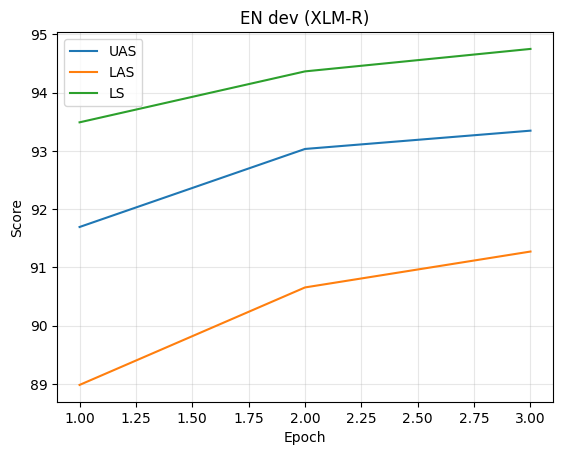

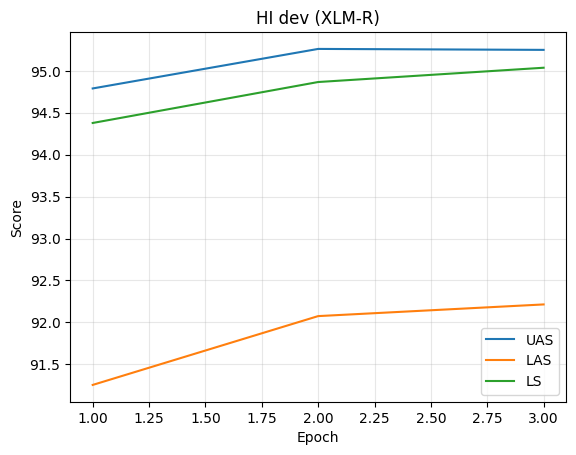

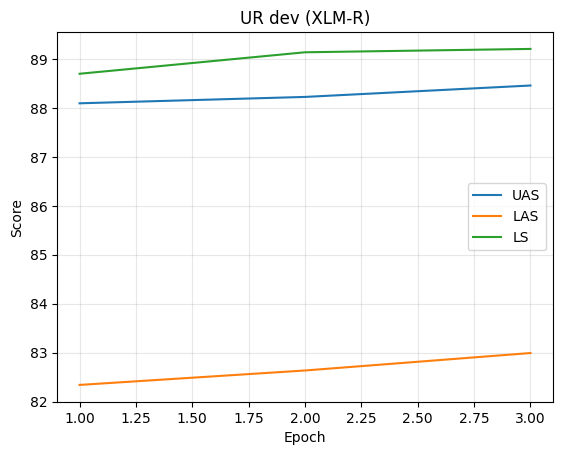

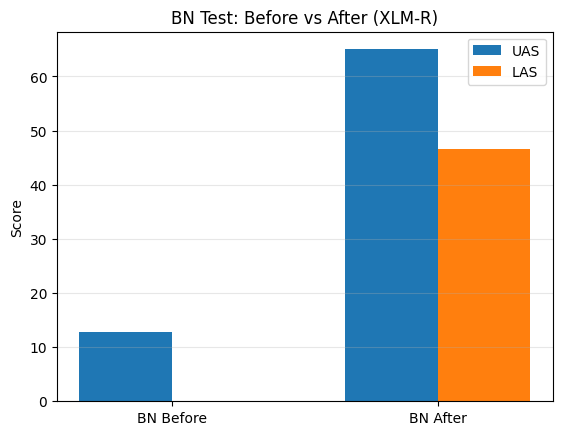

Saved plots: xlmr_en_dev.png, xlmr_hi_dev.png, xlmr_ur_dev.png, xlmr_bn_before_after.png


In [20]:
def plot_history(hist, title, fname):
    xs  = [h["epoch"] for h in hist]
    uas = [h["UAS"] for h in hist]
    las = [h["LAS"] for h in hist]
    ls  = [h["LS"]  for h in hist]
    plt.figure()
    plt.plot(xs, uas, label="UAS")
    plt.plot(xs, las, label="LAS")
    plt.plot(xs, ls,  label="LS")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title(title); plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(fname, dpi=140, bbox_inches="tight")
    plt.show()

print("\n=== COMPARISON TABLE ===")
rows = [
    ("BN test BEFORE", results["bn_before"]),
    ("EN dev after EN", results["en_dev"]),
    ("HI dev after HI", results["hi_dev"]),
    ("UR dev after UR", results["ur_dev"]),
    ("BN test AFTER", results["bn_after"]),
]
for name, m in rows:
    print(f"{name:20s} -> UAS={m['UAS']:.2f}  LAS={m['LAS']:.2f}  LS={m['LS']:.2f}")

plot_history(hist_en, "EN dev (XLM-R)", "xlmr_en_dev.png")
plot_history(hist_hi, "HI dev (XLM-R)", "xlmr_hi_dev.png")
plot_history(hist_ur, "UR dev (XLM-R)", "xlmr_ur_dev.png")

# BN before vs after
labels = ["BN Before", "BN After"]
uas_vals = [results["bn_before"]["UAS"], results["bn_after"]["UAS"]]
las_vals = [results["bn_before"]["LAS"], results["bn_after"]["LAS"]]

x = np.arange(2); w = 0.35
plt.figure()
plt.bar(x - w/2, uas_vals, width=w, label="UAS")
plt.bar(x + w/2, las_vals, width=w, label="LAS")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("BN Test: Before vs After (XLM-R)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.savefig("xlmr_bn_before_after.png", dpi=140, bbox_inches="tight")
plt.show()

print("Saved plots: xlmr_en_dev.png, xlmr_hi_dev.png, xlmr_ur_dev.png, xlmr_bn_before_after.png")


# Joint multilingual trainer (round-robin across EN/HI/UR)# 


In [21]:
# Joint multilingual training utilities (round-robin mixing per epoch)

from itertools import cycle

def _move_to(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    if isinstance(x, (list, tuple)):
        return type(x)(_move_to(xx, device) for xx in x)
    return x

def _one_step(model, batch, opt):
    (input_ids, attn_mask, ws, Lw, gold_h, gold_r, mw, _upos) = batch
    input_ids = input_ids.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)
    ws = ws.to(DEVICE)
    gold_h = gold_h.to(DEVICE)
    gold_r = gold_r.to(DEVICE)
    mw = mw.to(DEVICE)

    s_arc, s_rel = model(input_ids, attn_mask, ws, mw)
    loss, la, lr_ = compute_loss(s_arc, s_rel, gold_h, gold_r, mw)
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    return loss.item(), la, lr_

@torch.no_grad()
def eval_all_langs(model, dev_loaders_dict, keep_punct=True):
    # returns per-lang metrics and their macro average (by LAS)
    per_lang = {}
    for lk, loader in dev_loaders_dict.items():
        per_lang[lk] = eval_loader(model, loader, keep_punct=keep_punct)
    # macro averages
    avg = {
        "UAS": sum(m["UAS"] for m in per_lang.values()) / len(per_lang),
        "LAS": sum(m["LAS"] for m in per_lang.values()) / len(per_lang),
        "LS":  sum(m["LS"]  for m in per_lang.values()) / len(per_lang),
    }
    return per_lang, avg

def joint_train_round_robin(model, train_loaders_dict, dev_loaders_dict,
                            *, epochs:int, lr:float, save_path:str,
                            print_every:int=100):
    """
    Round-robin: in each epoch, we iterate over the three train loaders in turn.
    Epoch ends when all loaders are exhausted once (i.e., we traverse up to the max #batches).
    Best checkpoint is selected by *average LAS* across EN/HI/UR dev sets.
    """
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best_avg_las = -1.0
    history = []
    step = 0

    # Pre-build per-epoch batch counts
    lang_keys = list(train_loaders_dict.keys())

    for ep in range(1, epochs+1):
        # fresh iterators each epoch
        iters = {lk: iter(train_loaders_dict[lk]) for lk in lang_keys}
        finished = {lk: False for lk in lang_keys}
        losses_running = 0.0
        steps_running = 0

        # Continue until all loaders are exhausted
        while not all(finished.values()):
            for lk in lang_keys:
                if finished[lk]:
                    continue
                try:
                    batch = next(iters[lk])
                except StopIteration:
                    finished[lk] = True
                    continue
                # one optimization step
                loss_val, la, lr_ = _one_step(model, batch, opt)
                step += 1
                steps_running += 1
                losses_running += loss_val
                if step % print_every == 0:
                    print(f"[ep {ep} step {step} | {lk}] loss={losses_running/max(1,print_every):.4f} (arc={la:.3f} rel={lr_:.3f})")
                    losses_running = 0.0

        # end epoch → evaluate on all devs
        per_lang, avg = eval_all_langs(model, dev_loaders_dict, keep_punct=True)
        history.append({"epoch": ep, "avg": avg, "per_lang": per_lang})
        print(f"Epoch {ep} DEV avg -> UAS={avg['UAS']:.2f}  LAS={avg['LAS']:.2f}  (LS={avg['LS']:.2f})")
        for lk in lang_keys:
            m = per_lang[lk]
            print(f"  - {lk:7s}: UAS={m['UAS']:.2f}  LAS={m['LAS']:.2f}  (LS={m['LS']:.2f})")

        # model selection by average LAS
        if avg["LAS"] > best_avg_las:
            best_avg_las = avg["LAS"]
            torch.save({"state_dict": model.state_dict(),
                        "selector": "avg_LAS_EN_HI_UR",
                        "epoch": ep,
                        "avg_metrics": avg,
                        "per_lang": per_lang},
                       save_path)
            print(f"  -> Saved BEST-JOINT to {save_path} (avg LAS={best_avg_las:.2f})")

    return history, best_avg_las


Loaded previous best checkpoint: final-UR-xlmr.ckpt

[JOINT-0] BN test BEFORE joint training
BN before joint: {'UAS': 65.0, 'LAS': 46.5625, 'LS': 60.9375}

[JOINT-1] Joint training on EN+HI+UR
[ep 1 step 100 | en_ewt] loss=0.5000 (arc=0.108 rel=0.381)
[ep 1 step 200 | hi_hdtb] loss=0.2851 (arc=0.192 rel=0.075)
[ep 1 step 300 | ur_udtb] loss=0.2279 (arc=0.182 rel=0.343)
[ep 1 step 400 | en_ewt] loss=0.2174 (arc=0.052 rel=0.089)
[ep 1 step 500 | hi_hdtb] loss=0.2159 (arc=0.027 rel=0.118)
[ep 1 step 600 | ur_udtb] loss=0.2194 (arc=0.217 rel=0.126)
[ep 1 step 700 | en_ewt] loss=0.1829 (arc=0.134 rel=0.102)
[ep 1 step 800 | hi_hdtb] loss=0.1950 (arc=0.042 rel=0.034)
[ep 1 step 900 | ur_udtb] loss=0.1917 (arc=0.076 rel=0.180)
[ep 1 step 1000 | en_ewt] loss=0.2015 (arc=0.190 rel=0.022)
[ep 1 step 1100 | hi_hdtb] loss=0.1892 (arc=0.129 rel=0.079)
[ep 1 step 1200 | ur_udtb] loss=0.1970 (arc=0.134 rel=0.100)
[ep 1 step 1300 | en_ewt] loss=0.1952 (arc=0.063 rel=0.032)
[ep 1 step 1400 | hi_hdtb] l

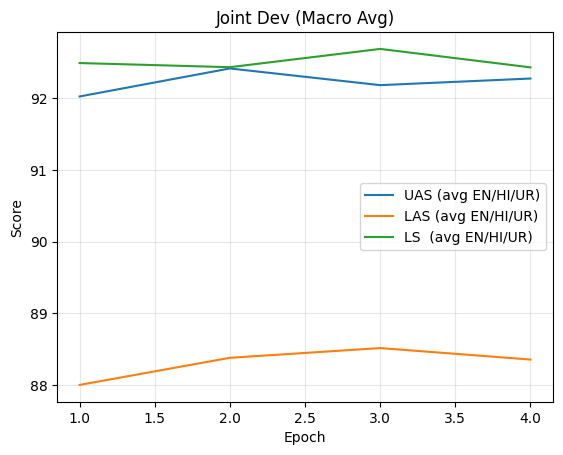

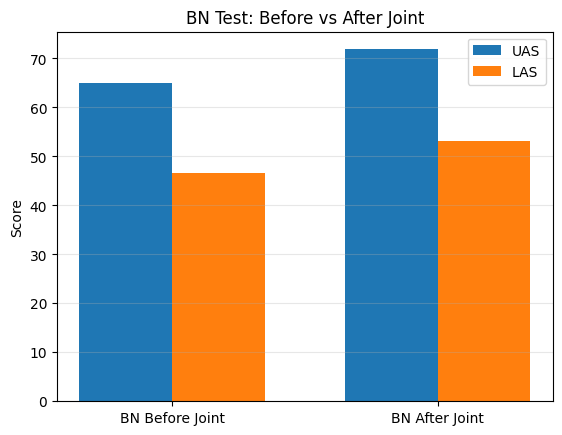


Artifacts:
 - best joint ckpt: checkpoints_xlmr/best-JOINT-xlmr.ckpt
 - history/results: xlmr_joint_histories.json
 - plots: xlmr_joint_dev_avg.png, xlmr_bn_before_after_joint.png


In [24]:
# 1) Build train/dev loaders per language (reuse your subword dataset & collate)
#    You likely created these earlier; we rebuild to be safe with bsz that fits T4.

_, _, en_tr_joint, en_de_joint = make_loaders("en_ewt", bsz=8, shuffle=True)
_, _, hi_tr_joint, hi_de_joint = make_loaders("hi_hdtb", bsz=8, shuffle=True)
_, _, ur_tr_joint, ur_de_joint = make_loaders("ur_udtb", bsz=8, shuffle=True)
bn_ds_joint, bn_ts_joint = make_test_loader(ZERO_SHOT_TEST_LANG, split="test", bsz=16)

train_loaders = {
    "en_ewt": en_tr_joint,
    "hi_hdtb": hi_tr_joint,
    "ur_udtb": ur_tr_joint,
}
dev_loaders = {
    "en_ewt": en_de_joint,
    "hi_hdtb": hi_de_joint,
    "ur_udtb": ur_de_joint,
}

# 2) Initialize model and LOAD the best checkpoint from your previous sequential run
CHECKPOINT_DIR = Path("./checkpoints_xlmr")
ckpt_en = CHECKPOINT_DIR / "best-EN-xlmr.ckpt"
ckpt_hi = CHECKPOINT_DIR / "best-HI-xlmr.ckpt"
ckpt_ur = CHECKPOINT_DIR / "final-UR-xlmr.ckpt"
ckpt_joint = CHECKPOINT_DIR / "best-JOINT-xlmr.ckpt"

model = XLMRParser(MODEL_NAME, rel_size=NUM_REL, mlp_arc=600, mlp_rel=150, dropout=0.33).to(DEVICE)

loaded_from = None
for path_try in [ckpt_ur, ckpt_hi, ckpt_en]:
    if path_try.exists():
        state = torch.load(path_try, map_location=DEVICE)
        model.load_state_dict(state["state_dict"])
        loaded_from = path_try.name
        break

if loaded_from is None:
    print("WARNING: No previous checkpoints found; starting joint training from scratch.")
else:
    print(f"Loaded previous best checkpoint: {loaded_from}")

# 3) Evaluate BN BEFORE joint (for reference)
results_joint = {}
print("\n[JOINT-0] BN test BEFORE joint training")
results_joint["bn_before_joint"] = eval_loader(model, bn_ts_joint, keep_punct=True)
print("BN before joint:", results_joint["bn_before_joint"])

# 4) Joint train (round-robin mix EN/HI/UR)
print("\n[JOINT-1] Joint training on EN+HI+UR")
hist_joint, best_avg_las = joint_train_round_robin(
    model, train_loaders, dev_loaders,
    epochs=4,       # start with 2; bump to 3–4 if you have time
    lr=2e-5,        # standard XLM-R fine-tune rate
    save_path=str(ckpt_joint),
    print_every=100
)

# 5) Load BEST-JOINT and evaluate devs + BN AFTER
if ckpt_joint.exists():
    state = torch.load(ckpt_joint, map_location=DEVICE)
    model.load_state_dict(state["state_dict"])
    print(f"\nLoaded BEST-JOINT checkpoint (epoch={state.get('epoch','?')}, selector={state.get('selector','')}).")

per_lang_after, avg_after = eval_all_langs(model, dev_loaders, keep_punct=True)
results_joint["dev_after_joint_avg"] = avg_after
results_joint["dev_after_joint_per_lang"] = per_lang_after

print("\n[JOINT-2] Dev after joint (macro avg):", avg_after)
for lk, m in per_lang_after.items():
    print(f"  - {lk:7s}: UAS={m['UAS']:.2f}  LAS={m['LAS']:.2f}  (LS={m['LS']:.2f})")

print("\n[JOINT-3] BN test AFTER joint training")
results_joint["bn_after_joint"] = eval_loader(model, bn_ts_joint, keep_punct=True)
print("BN after joint:", results_joint["bn_after_joint"])

# 6) Save history & results
with open("xlmr_joint_histories.json", "w") as f:
    json.dump({"hist_joint": hist_joint,
               "results_joint": results_joint}, f, indent=2)

# 7) Quick plots: per-epoch macro avg UAS/LAS/LS for joint, and BN before vs after joint
xs = [h["epoch"] for h in hist_joint]
uas = [h["avg"]["UAS"] for h in hist_joint]
las = [h["avg"]["LAS"] for h in hist_joint]
ls  = [h["avg"]["LS"]  for h in hist_joint]

plt.figure()
plt.plot(xs, uas, label="UAS (avg EN/HI/UR)")
plt.plot(xs, las, label="LAS (avg EN/HI/UR)")
plt.plot(xs, ls,  label="LS  (avg EN/HI/UR)")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Joint Dev (Macro Avg)")
plt.legend(); plt.grid(alpha=0.3)
plt.savefig("xlmr_joint_dev_avg.png", dpi=140, bbox_inches="tight")
plt.show()

labels = ["BN Before Joint", "BN After Joint"]
uas_vals = [results_joint["bn_before_joint"]["UAS"], results_joint["bn_after_joint"]["UAS"]]
las_vals = [results_joint["bn_before_joint"]["LAS"], results_joint["bn_after_joint"]["LAS"]]

x = np.arange(2); w = 0.35
plt.figure()
plt.bar(x - w/2, uas_vals, width=w, label="UAS")
plt.bar(x + w/2, las_vals, width=w, label="LAS")
plt.xticks(x, labels)
plt.ylabel("Score"); plt.title("BN Test: Before vs After Joint")
plt.legend(); plt.grid(axis="y", alpha=0.3)
plt.savefig("xlmr_bn_before_after_joint.png", dpi=140, bbox_inches="tight")
plt.show()

print("\nArtifacts:")
print(" - best joint ckpt:", ckpt_joint)
print(" - history/results: xlmr_joint_histories.json")
print(" - plots: xlmr_joint_dev_avg.png, xlmr_bn_before_after_joint.png")


In [25]:
# ===== Cell: Load best checkpoint & manually test dependency parsing =====
import torch, os
from pathlib import Path

# --- Reuse or (re)init essentials ---
try:
    XLMRParser
except NameError:
    from transformers import AutoTokenizer
    MODEL_NAME = "xlm-roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    # Minimal MLP/Biaffine from earlier (must match your model code)
    import torch.nn as nn
    class MLP(nn.Module):
        def __init__(self, in_dim, out_dim, p=0.33):
            super().__init__()
            self.fc = nn.Linear(in_dim, out_dim)
            self.act = nn.LeakyReLU(0.1)
            self.drop = nn.Dropout(p)
        def forward(self, x): return self.drop(self.act(self.fc(x)))
    class Biaffine(nn.Module):
        def __init__(self, in1, in2, out=1, bias_x=True, bias_y=True):
            super().__init__()
            self.bias_x = bias_x; self.bias_y = bias_y
            self.U = nn.Parameter(torch.empty(out, in1 + bias_x, in2 + bias_y))
            nn.init.xavier_uniform_(self.U)
        def forward(self, x, y):
            if self.bias_x: x = torch.cat([x, x.new_ones(x.size(0), x.size(1), 1)], dim=-1)
            if self.bias_y: y = torch.cat([y, y.new_ones(y.size(0), y.size(1), 1)], dim=-1)
            return torch.einsum("bxi,oij,byj->boxy", x, self.U, y)
    from transformers import AutoModel
    class XLMRParser(nn.Module):
        def __init__(self, model_name:str, rel_size:int, mlp_arc=600, mlp_rel=150, dropout=0.33):
            super().__init__()
            self.encoder = AutoModel.from_pretrained(model_name)
            hid = self.encoder.config.hidden_size
            self.root = nn.Parameter(torch.zeros(1, 1, hid))
            nn.init.xavier_uniform_(self.root)
            self.mlp_arc_h = MLP(hid, mlp_arc, dropout)
            self.mlp_arc_d = MLP(hid, mlp_arc, dropout)
            self.mlp_rel_h = MLP(hid, mlp_rel, dropout)
            self.mlp_rel_d = MLP(hid, mlp_rel, dropout)
            self.arc_biaff = Biaffine(mlp_arc, mlp_arc, out=1)
            self.rel_biaff = Biaffine(mlp_rel, mlp_rel, out=rel_size)
        def select_word_reps(self, enc_out, word_starts):
            B, _, H = enc_out.size()
            T = word_starts.size(1)
            idx = word_starts.clamp(min=0).unsqueeze(-1).expand(B, T, H)
            gathered = enc_out.gather(1, idx)
            root = self.root.expand(B, 1, -1)
            gathered[:, :1, :] = root
            return gathered
        def forward(self, input_ids, attn_mask, word_starts, mask_words=None):
            enc = self.encoder(input_ids=input_ids, attention_mask=attn_mask).last_hidden_state
            words_H = self.select_word_reps(enc, word_starts)
            arc_h = self.mlp_arc_h(words_H)
            arc_d = self.mlp_arc_d(words_H)
            rel_h = self.mlp_rel_h(words_H)
            rel_d = self.mlp_rel_d(words_H)
            s_arc = self.arc_biaff(arc_d, arc_h).squeeze(1)     # [B,T,T]
            s_rel = self.rel_biaff(rel_d, rel_h)                # [B,R,T,T]
            return s_arc, s_rel

try:
    DEVICE
except NameError:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    id2rel
    NUM_REL
except NameError:
    # Fallback (only if earlier cells weren't run) — minimal 1-label space
    id2rel = ["root"]
    NUM_REL = 1
    print("WARNING: rel label vocab not found. Using a minimal placeholder.")

# --- Helper: build subword alignment for a given tokenized sentence ---
def _encode_words(words):
    # expects 'words' WITHOUT ROOT; we'll add "<ROOT>" as word 0 for head indexing
    words_root = ["<ROOT>"] + words
    enc = tokenizer(words_root, is_split_into_words=True, return_tensors="pt")
    word_ids = enc.word_ids()
    first_idx = {}
    for i, wid in enumerate(word_ids):
        if wid is None: 
            continue
        if wid not in first_idx:
            first_idx[wid] = i
    word_starts = [first_idx[w] for w in range(len(words_root))]
    input_ids = enc["input_ids"]
    attn_mask = enc["attention_mask"]
    return input_ids, attn_mask, torch.tensor([word_starts], dtype=torch.long), words_root

# --- Helper: decode heads/labels (single batch) ---
@torch.no_grad()
def _decode_heads_labels(scores_arc, scores_rel):
    # scores_arc: [1,T,T], scores_rel: [1,R,T,T]
    heads = scores_arc.argmax(-1)            # [1,T]
    B, R, T, _ = scores_rel.size()
    head_idx = heads.unsqueeze(1).unsqueeze(-1).expand(B, R, T, 1)
    rel_sel = torch.gather(scores_rel, 3, head_idx).squeeze(3)  # [1,R,T]
    rels = rel_sel.argmax(1)                                    # [1,T]
    return heads.squeeze(0).tolist(), rels.squeeze(0).tolist()

# --- Loader for best checkpoint ---
def load_best_model():
    ckpt_dir = Path("./checkpoints_xlmr")
    order = ["best-JOINT-xlmr.ckpt", "final-UR-xlmr.ckpt", "best-HI-xlmr.ckpt", "best-EN-xlmr.ckpt"]
    found = None
    for name in order:
        p = ckpt_dir / name
        if p.exists():
            found = p
            break
    model = XLMRParser(MODEL_NAME, rel_size=NUM_REL, mlp_arc=600, mlp_rel=150, dropout=0.33).to(DEVICE)
    if found is None:
        print("No checkpoint found. Using randomly initialized model.")
        return model, None
    state = torch.load(found, map_location=DEVICE)
    model.load_state_dict(state["state_dict"])
    model.eval()
    print(f"Loaded checkpoint: {found.name}")
    return model, str(found)

# --- Pretty printers ---
def print_table(words, heads, rels):
    # words include ROOT at 0; print from 1..T-1
    print("{:<4} {:<20} {:<6} {}".format("ID", "FORM", "HEAD", "DEPREL"))
    for i in range(1, len(words)):
        hid = heads[i]
        rel = id2rel[rels[i]] if rels[i] < len(id2rel) else str(rels[i])
        print("{:<4} {:<20} {:<6} {}".format(i, words[i], hid, rel))

def to_conllu(words, heads, rels):
    # minimal CoNLL-U: ID FORM _ UPOS _ HEAD DEPREL _ _
    lines = []
    for i in range(1, len(words)):
        hid = heads[i]
        rel = id2rel[rels[i]] if rels[i] < len(id2rel) else "dep"
        # fields: ID FORM LEMMA UPOS XPOS FEATS HEAD DEPREL DEPS MISC
        line = f"{i}\t{words[i]}\t_\t_\t_\t_\t{hid}\t{rel}\t_\t_"
        lines.append(line)
    return "\n".join(lines)

# --- Public API: parse a raw string or pre-tokenized list ---
@torch.no_grad()
def parse_text(text_or_tokens, model=None, show=True):
    if isinstance(text_or_tokens, str):
        # naive whitespace tokenization; for Bengali/Hindi/Urdu this is usually fine for a quick check
        tokens = text_or_tokens.strip().split()
    else:
        tokens = list(text_or_tokens)

    if model is None:
        model, _ = load_best_model()

    # encode & forward
    input_ids, attn_mask, word_starts, words_root = _encode_words(tokens)
    input_ids = input_ids.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)
    word_starts = word_starts.to(DEVICE)

    s_arc, s_rel = model(input_ids, attn_mask, word_starts, None)
    heads, rels = _decode_heads_labels(s_arc, s_rel)

    if show:
        print("\n=== Parsed Dependencies ===")
        print_table(words_root, heads, rels)
        print("\n# CoNLL-U")
        print(to_conllu(words_root, heads, rels))
    return {
        "tokens": words_root[1:],     # exclude ROOT
        "heads": heads[1:],
        "rels":  [id2rel[r] if r < len(id2rel) else str(r) for r in rels[1:]],
        "conllu": to_conllu(words_root, heads, rels)
    }

# ---------- Demo ----------
model, ckpt_used = load_best_model()


_ = parse_text("নোবেলজয়ী বাঙালি কবি রবীন্দ্রনাথ ঠাকুরের দুইটি বাংলা কবিতা বাংলাদেশ ও ভারতের জাতীয় সংগীত হিসেবে গৃহীত হয়", model=model)

# Hindi:
# _ = parse_text("लड़का किताब पढ़ रहा है ।")

# Urdu:
# _ = parse_text("لڑکا کتاب پڑھ رہا ہے ۔")



Loaded checkpoint: best-JOINT-xlmr.ckpt

=== Parsed Dependencies ===
ID   FORM                 HEAD   DEPREL
1    নোবেলজয়ী            3      amod
2    বাঙালি               1      amod
3    কবি                  5      nmod
4    রবীন্দ্রনাথ          5      compound
5    ঠাকুরের              8      nmod
6    দুইটি                8      nummod
7    বাংলা                8      amod
8    কবিতা                16     nsubj
9    বাংলাদেশ             13     nmod
10   ও                    11     cc
11   ভারতের               9      conj
12   জাতীয়               13     amod
13   সংগীত                16     obl
14   হিসেবে               13     case
15   গৃহীত                16     compound
16   হয়                  0      root

# CoNLL-U
1	নোবেলজয়ী	_	_	_	_	3	amod	_	_
2	বাঙালি	_	_	_	_	1	amod	_	_
3	কবি	_	_	_	_	5	nmod	_	_
4	রবীন্দ্রনাথ	_	_	_	_	5	compound	_	_
5	ঠাকুরের	_	_	_	_	8	nmod	_	_
6	দুইটি	_	_	_	_	8	nummod	_	_
7	বাংলা	_	_	_	_	8	amod	_	_
8	কবিতা	_	_	_	_	16	nsubj	_	_
9	বাংলাদেশ	_	_	_	_	13	nmod	_	